<a href="https://colab.research.google.com/github/sowrabh-adiga/cybersec/blob/main/side_channel_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import Counter

Assume that the site we are trying to acess does password check by comparing bit by bit with entered password and also assume that the below cell is a black box whose contents arent visible to others.

In [2]:
# Black box

# The vulnerable password check function, this cell is assumed to be a external site we are trying to access
password = "9875"

def unlock(key):
    """
    Simulates a password verification process vulnerable to timing attacks.
    """
    if len(key) != len(password):
        return False

    for i in range(len(key)):
        if key[i] == password[i]:
            continue
        else:
            return False
    return True




# def unlock(key):
#   if len(key) != len(password):
#     print("No match ! Hint:Wrong length")
#     return False
#   delay_per_char = 0.00001
#   for i in range(len(key)):
#     time.sleep(delay_per_char)
#     if key[i] == password[i]:
#       continue
#     else:
#       # print(f"passwords not matching, {key}")
#       return False
#   #print("passwords matching")
#   return True

Function to run a single digit simulation and return the best guess

First try with mean resulted im outliers swinging the results very frquently

Just median also swings values but less frequent as compared to mean

In the current approch I combined the median with max occurance in estimates (not mode)

------------------------------


the main idea is :`Record the max value in the list of median delays for each digits`


------------------------------
Approach used to make the results more reliable:

First find median delay for combinations from (0-9) over many trials, then find the max number of times a number has been estimated in the 10 simulations

Starting best-estimate-experiment: 10 runs, each with 500000 trials.
The final result will be the most common guess across all runs.

--- Running Best_Estimate-Experiment Iteration 1/10 ---
Iteration 1 best guess: 3

--- Running Best_Estimate-Experiment Iteration 2/10 ---
Iteration 2 best guess: 9

--- Running Best_Estimate-Experiment Iteration 3/10 ---
Iteration 3 best guess: 9

--- Running Best_Estimate-Experiment Iteration 4/10 ---
Iteration 4 best guess: 9

--- Running Best_Estimate-Experiment Iteration 5/10 ---
Iteration 5 best guess: 0

--- Running Best_Estimate-Experiment Iteration 6/10 ---
Iteration 6 best guess: 9

--- Running Best_Estimate-Experiment Iteration 7/10 ---
Iteration 7 best guess: 9

--- Running Best_Estimate-Experiment Iteration 8/10 ---
Iteration 8 best guess: 9

--- Running Best_Estimate-Experiment Iteration 9/10 ---
Iteration 9 best guess: 0

--- Running Best_Estimate-Experiment Iteration 10/10 ---
Iteration 10 best guess: 9

--- Final Results ---
All guesses 

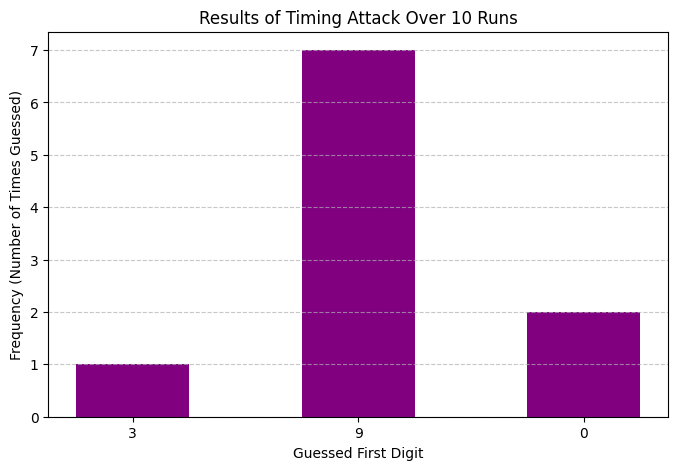

In [4]:
def run_single_simulation(numTrials, passwordLen):
    """Runs a single timing simulation and returns the most likely first digit based on median time.

    Median selected as metric to rule out any outliers due to network or execution latency"""
    medianTimes = {}

    for firstDigit in range(10):
        testKey = str(firstDigit) + "0" * (passwordLen - 1)
        trialTimes = []

        # Using tqdm for a progress bar for each set of trials
        # for _ in tqdm(range(numTrials), desc=f"Testing '{testKey}'"):
        # -->> uncomment above 'for' line and comment the below 'for' line, to see each key combination being used
        for _ in range(numTrials):
            startTime = time.perf_counter()
            unlock(testKey)
            endTime = time.perf_counter()
            trialTimes.append(endTime - startTime)

        medianTimes[testKey] = np.median(trialTimes)

    # Find the key with the highest median time for this run
    estimatedKey = max(medianTimes, key=medianTimes.get)
    return estimatedKey[0] # Return just the digit

# 3. The main "best_estimate-experiment" loop
numTrials = 500000
bestEstimateRuns = 10
allGuesses = []

print(f"Starting best-estimate-experiment: {bestEstimateRuns} runs, each with {numTrials} trials.")
print("The final result will be the most common guess across all runs.\n")

for i in range(bestEstimateRuns):
    print(f"--- Running Best_Estimate-Experiment Iteration {i + 1}/{bestEstimateRuns} ---")
    bestGuess = run_single_simulation(numTrials, len(password))
    allGuesses.append(bestGuess)
    print(f"Iteration {i + 1} best guess: {bestGuess}\n")

# 4. Analyze the results from all the runs
guessCounts = Counter(allGuesses)
mostCommonGuess = guessCounts.most_common(1)[0][0]

print("--- Final Results ---")
print("All guesses from the best--experiment:", allGuesses)
print("Frequency of guesses:", guessCounts)
print(f"\nThe most frequent guess across all {bestEstimateRuns} runs is: '{mostCommonGuess}'")
print(f"The actual first digit of the password is: '{password[0]}'")

# Optional: Plotting the frequency of the guesses
labels, values = zip(*guessCounts.items())
indexes = np.arange(len(labels))
width = 0.5

plt.figure(figsize=(8, 5))
plt.bar(indexes, values, width, color='purple')
plt.xticks(indexes, labels)
plt.xlabel('Guessed First Digit')
plt.ylabel('Frequency (Number of Times Guessed)')
plt.title(f'Results of Timing Attack Over {bestEstimateRuns} Runs')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Function to find the full key with same logic as above (logic used for first digit)

One small change here is that the last digit in the key will have low delay as the code exits on finding the correct key. So just for last key we need to record min median value

In [4]:
# Function to run a full simulation for all digit position, following the above cell logic
def find_next_digit(prefix, numTrials, passwordLen):
    """
    Runs a simulation to find the next correct digit given a prefix.
    Returns the most likely digit based on the meta-experiment.
    """
    allGuesses = []
    bestEstimateRuns = 10 # Number of times to repeat the experiment

    print(f"\n--- Attacking Position {len(prefix) + 1} (prefix: '{prefix}') ---")

    for i in range(bestEstimateRuns):
        medianTimes = {}
        for guessDigit in range(10):
            # Construct the key: use the found prefix, the current guess, and pad the rest with '0'
            testKey = prefix + str(guessDigit) + "0" * (passwordLen - (len(prefix) + 1))

            trialTimes = []
            for _ in range(numTrials):
                startTime = time.perf_counter_ns()
                unlock(testKey)
                endTime = time.perf_counter_ns()
                trialTimes.append(endTime - startTime)

            medianTimes[guessDigit] = np.median(trialTimes)
        # Find the key with the highest median time for this single run
        # print(medianTimes)
        if len(prefix) < passwordLen -1:
          estimatedKey = max(medianTimes, key=medianTimes.get)
        else:
          estimatedKey = min(medianTimes, key=medianTimes.get)
        allGuesses.append(estimatedKey)

    # The above logic assumes that for all position other than last one the delay will be large and the delay will be smallest for last digit
    # Use Counter to find the most frequent guess across all meta-runs
    guessCounts = Counter(allGuesses)
    finalGuess = guessCounts.most_common(1)[0][0]
    # print(allGuesses)
    # print(guessCounts)
    print(f"Most likely digit is: '{finalGuess}'")

    return str(finalGuess)

# Function for sending in each key element for the simulation function
def find_full_password(passwordToCrack, numTrialsPerRun):
    foundPassword = ""
    passwordLen = len(passwordToCrack)

    print("Beginning timing side-channel attack to find the full password...")

    for _ in range(passwordLen):
        nextDigit = find_next_digit(foundPassword, numTrialsPerRun, passwordLen)
        foundPassword += nextDigit
        print(f"Password so far: '{foundPassword}'")

    return foundPassword

# Main body
if __name__ == "__main__":
    numTrialsPerRUN = 100000 # A reasonable number for demonstration for full-scale sweep
    guessedPassword = find_full_password(password, numTrialsPerRUN)
    if len(guessedPassword) == len(password):
      print("\n--- ATTACK SUCCESSFUL ---")
    else:
      print("Attack failed")
    print(f"The guessed password is: '{guessedPassword}'")
    print(f"The actual password is: '{password}'")

Beginning timing side-channel attack to find the full password...

--- Attacking Position 1 (prefix: '') ---
Most likely digit is: '9'
Password so far: '9'

--- Attacking Position 2 (prefix: '9') ---
Most likely digit is: '8'
Password so far: '98'

--- Attacking Position 3 (prefix: '98') ---
Most likely digit is: '7'
Password so far: '987'

--- Attacking Position 4 (prefix: '987') ---
Most likely digit is: '5'
Password so far: '9875'

--- ATTACK SUCCESSFUL ---
The guessed password is: '9875'
The actual password is: '9875'


Following the instructions on the video and implementing the code for 41 tries

In [5]:
# Implementation for 41 runs
def find_next_digit(prefix, num_trials, password_len):
    """
    Runs a simulation to find the next correct digit given a prefix.
    Returns the most likely digit based on the meta-experiment.
    """
    all_guesses = []
    NUM_META_RUNS = 1 # Number of times to repeat the experiment

    print(f"\n--- Attacking Position {len(prefix) + 1} (prefix: '{prefix}') ---")

    for i in range(NUM_META_RUNS):
        median_times = {}
        for guess_digit in range(10):
            # Construct the key: use the found prefix, the current guess, and pad the rest with '0'
            test_key = prefix + str(guess_digit) + "0" * (password_len - (len(prefix) + 1))

            trial_times = []
            for _ in range(num_trials):
                start_time = time.perf_counter_ns()
                unlock(test_key)
                end_time = time.perf_counter_ns()
                trial_times.append(end_time - start_time)

            median_times[guess_digit] = np.median(trial_times)

        # Find the key with the highest median time for this single run
        most_likely_digit = max(median_times, key=median_times.get)
        all_guesses.append(most_likely_digit)

    # Use Counter to find the most frequent guess across all meta-runs
    guess_counts = Counter(all_guesses)
    final_guess = guess_counts.most_common(1)[0][0]

    print(f"Meta-experiment results for position {len(prefix) + 1}: {guess_counts}")
    print(f"Most likely digit is: '{final_guess}'")

    return str(final_guess)

# 3. The main orchestration for the full attack
def find_full_password(password_to_crack, num_trials_per_run):
    found_password = ""
    password_len = len(password_to_crack)

    print("Beginning timing side-channel attack to find the full password...")

    for _ in range(password_len):
        next_digit = find_next_digit(found_password, num_trials_per_run, password_len)
        found_password += next_digit
        print(f"Password so far: '{found_password}'")

    return found_password

# Execute the full attack
if __name__ == "__main__":
    NUM_TRIALS_PER_RUN = 41 # A reasonable number for demonstration
    guessed_password = find_full_password(password, NUM_TRIALS_PER_RUN)

    # print("\n--- ATTACK SUCCESSFUL ---")
    print(f"The guessed password is: '{guessed_password}'")
    print(f"The actual password is: '{password}'")

Beginning timing side-channel attack to find the full password...

--- Attacking Position 1 (prefix: '') ---
Meta-experiment results for position 1: Counter({0: 1})
Most likely digit is: '0'
Password so far: '0'

--- Attacking Position 2 (prefix: '0') ---
Meta-experiment results for position 2: Counter({6: 1})
Most likely digit is: '6'
Password so far: '06'

--- Attacking Position 3 (prefix: '06') ---
Meta-experiment results for position 3: Counter({0: 1})
Most likely digit is: '0'
Password so far: '060'

--- Attacking Position 4 (prefix: '060') ---
Meta-experiment results for position 4: Counter({6: 1})
Most likely digit is: '6'
Password so far: '0606'
The guessed password is: '0606'
The actual password is: '9875'
